In [5]:
import pandas as pd

train_df = pd.read_csv('Titanic_train.csv')
test_df = pd.read_csv('Titanic_test.csv')

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)


Train shape: (891, 12)
Test shape: (418, 11)


Missing values in training data:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Missing values in test data:
 PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

Train data description:
        PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.00

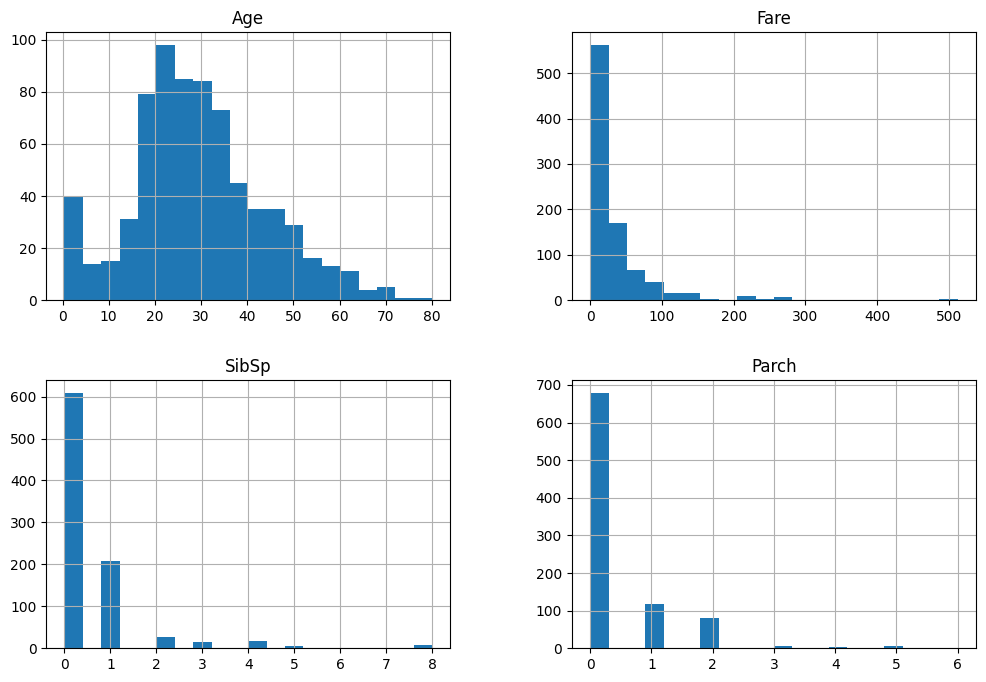

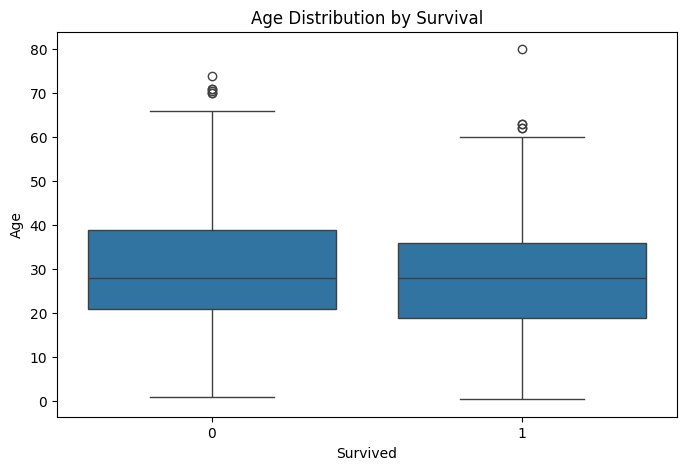

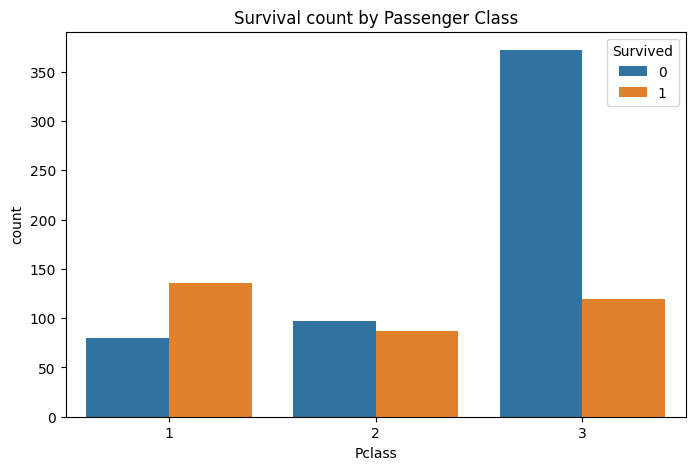

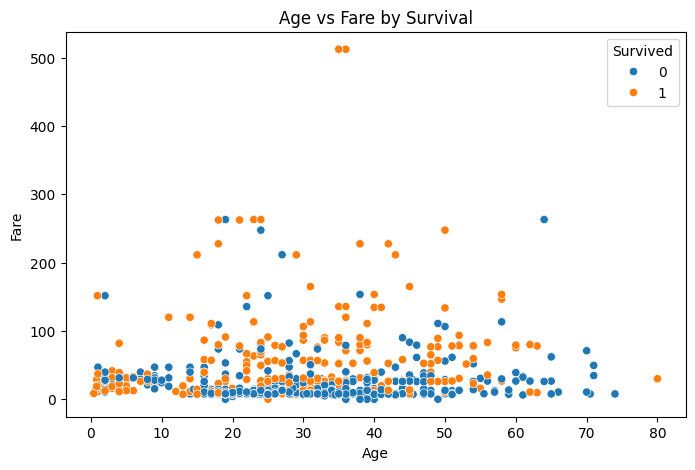

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Check for missing values
print("Missing values in training data:\n", train_df.isnull().sum())
print("\nMissing values in test data:\n", test_df.isnull().sum())

# Summary statistics
print("\nTrain data description:\n", train_df.describe())

# Histograms for numerical features
train_df.hist(['Age', 'Fare', 'SibSp', 'Parch'], bins=20, figsize=(12,8))
plt.show()

# Box plots for Age by Survival
plt.figure(figsize=(8,5))
sns.boxplot(x='Survived', y='Age', data=train_df)
plt.title('Age Distribution by Survival')
plt.show()

# Bar plot of survival counts by Pclass
plt.figure(figsize=(8,5))
sns.countplot(x='Pclass', hue='Survived', data=train_df)
plt.title('Survival count by Passenger Class')
plt.show()

# Scatter plot Age vs Fare colored by Survival
plt.figure(figsize=(8,5))
sns.scatterplot(x='Age', y='Fare', hue='Survived', data=train_df)
plt.title('Age vs Fare by Survival')
plt.show()


In [15]:
import pandas as pd
from sklearn.impute import SimpleImputer


# Combine train (without target) and test for uniform preprocessing
full_df = pd.concat([train_df.drop(columns=['Survived']), test_df], axis=0, ignore_index=True)

# Impute numeric columns
imputer_num = SimpleImputer(strategy='median')
full_df['Age'] = imputer_num.fit_transform(full_df[['Age']])
full_df['Fare'] = imputer_num.fit_transform(full_df[['Fare']])

# Impute categorical column
imputer_cat = SimpleImputer(strategy='most_frequent')
full_df['Embarked'] = imputer_cat.fit_transform(full_df[['Embarked']]).ravel()

# Drop unnecessary columns
full_df.drop(columns=['Cabin', 'Ticket', 'Name', 'PassengerId'], inplace=True)

# One-hot encode categorical columns
full_df = pd.get_dummies(full_df, columns=['Sex', 'Embarked'], drop_first=True)

# Split back into train and test sets
n_train = train_df.shape[0]
X_train = full_df.iloc[:n_train, :]
X_test = full_df.iloc[n_train:, :]
y_train = train_df['Survived']

print('Preprocessing completed successfully.')
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)


Preprocessing completed successfully.
X_train shape: (891, 8)
X_test shape: (418, 8)
y_train shape: (891,)


In [22]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Split the training data into a smaller training set and a validation set
X_train_part, X_val, y_train_part, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

# Define the evaluation function
def evaluate_model(y_true, y_pred):
    print(f"Accuracy:  {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred, zero_division=0):.4f}")
    print(f"Recall:    {recall_score(y_true, y_pred, zero_division=0):.4f}")
    print(f"F1 Score:  {f1_score(y_true, y_pred, zero_division=0):.4f}")

print("--- Data Split ---")
print("Training data shape:", X_train_part.shape)
print("Validation data shape:", X_val.shape)
print("\nEvaluation function is ready.")


--- Data Split ---
Training data shape: (712, 8)
Validation data shape: (179, 8)

Evaluation function is ready.


In [23]:
import lightgbm as lgb

# Initialize and train the LightGBM model
lgb_model = lgb.LGBMClassifier(random_state=42)
lgb_model.fit(X_train_part, y_train_part)

# Make predictions on the validation set
y_pred_lgb = lgb_model.predict(X_val)

# Evaluate the model
print("--- LightGBM Model Performance ---")
evaluate_model(y_val, y_pred_lgb)


[LightGBM] [Info] Number of positive: 268, number of negative: 444
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000440 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 195
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.376404 -> initscore=-0.504838
[LightGBM] [Info] Start training from score -0.504838
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [24]:
import xgboost as xgb

# Initialize and train the XGBoost model
xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_part, y_train_part)

# Make predictions on the validation set
y_pred_xgb = xgb_model.predict(X_val)

# Evaluate the model
print("--- XGBoost Model Performance ---")
evaluate_model(y_val, y_pred_xgb)


--- XGBoost Model Performance ---
Accuracy:  0.8045
Precision: 0.7671
Recall:    0.7568
F1 Score:  0.7619


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [14:56:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


--- Model Comparison ---
           LightGBM   XGBoost
Metric                       
Accuracy   0.826816  0.804469
Precision  0.794521  0.767123
Recall     0.783784  0.756757
F1 Score   0.789116  0.761905


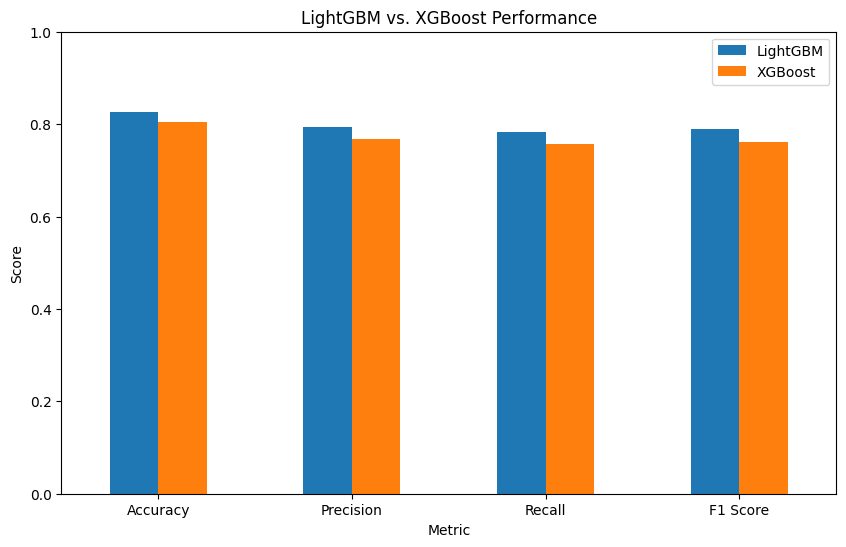

In [25]:
# Create a dictionary to hold the performance metrics
metrics_data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'LightGBM': [
        accuracy_score(y_val, y_pred_lgb),
        precision_score(y_val, y_pred_lgb),
        recall_score(y_val, y_pred_lgb),
        f1_score(y_val, y_pred_lgb)
    ],
    'XGBoost': [
        accuracy_score(y_val, y_pred_xgb),
        precision_score(y_val, y_pred_xgb),
        recall_score(y_val, y_pred_xgb),
        f1_score(y_val, y_pred_xgb)
    ]
}

# Create a DataFrame for easy plotting
metrics_df = pd.DataFrame(metrics_data).set_index('Metric')

# Print the comparison table
print("--- Model Comparison ---")
print(metrics_df)

# Visualize the comparison
metrics_df.plot(kind='bar', figsize=(10, 6))
plt.title('LightGBM vs. XGBoost Performance')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.show()
